# Градиентный спуск

In [19]:
import math
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy.optimize import line_search
plt.rcParams["figure.figsize"] = (20, 10)

EPS = 1e-6
MAX_EPOCH = 100000


def distance(x, y):
    return np.linalg.norm(x - y)


class Function:
    def __init__(self, function, grad, min_point=(0, 0)):
        self.call = function
        self.grad = grad
        self.min_point = min_point

    def __call__(self, point):
        return self.call(point)

    def grad(self, point): return self.grad(point)    


def make_point(x, y): return np.array((x, y))

def draw_function(f):
    t = np.linspace(-5, 5, 100)
    x, y = np.meshgrid(t, t)
    ax = plt.figure().add_subplot(projection='3d')
    ax.plot_surface(x, y, f((x, y)))

def draw_gradient(f, points):
    colors = ['b', 'g', 'm', 'c', 'orange']
    t = np.linspace(-5, 5, 100)
    X, Y = np.meshgrid(t, t)
    fig, (ax1, ax2) = plt.subplots(1, 2)
    ax1.plot(f((points[:, 0], points[:, 1])), lw=2, color=colors[0], )
    ax1.grid()

    Z = f([X, Y])
    cp = ax2.contourf(X, Y, Z)
    fig.colorbar(cp)
    ax2.plot(points[:, 0], points[:, 1], 'o-', color='r')

In [20]:
def abstract_gradient_descent(first_point, next_point_fun, stop_criteria):
    points = np.array([first_point])
    x = first_point
    epoch = 0
    while not stop_criteria(x) and epoch < MAX_EPOCH:
        x = next_point_fun(x, epoch)
        points = np.append(points, [x], axis=0)
        epoch += 1
    return points


def stop_by_grad(f):
    return lambda x: np.linalg.norm(f.grad(x)) < EPS


def lin_rate_grad_descent(f, first_point, lin_rate):
    next_point = lambda x, epoch: x - lin_rate(epoch) * np.array(f.grad(x))
    return abstract_gradient_descent(first_point, next_point, stop_by_grad(f))

Посмотрим, за сколько шагов наш градиентный спуск приходит к минимуму в зависимости от параметра linear_rate

In [21]:
def test_const_lin_rate(f, first_point, grad_descent, test_list):
    def run(lr):
        return grad_descent(f, first_point, lambda _: lr)

    ans = pd.DataFrame()
    ans["Linear rate"] = test_list
    ans["Epochs"] = list(map(len, map(run, test_list)))
    return ans


lin_rate_test_list = list(i for i in np.arange(0.2, 1, 0.1))
test_const_lin_rate(fun, make_point(2, 1), lin_rate_grad_descent, lin_rate_test_list)

,Linear rate,Epochs
0,0.2,65
1,0.3,41
2,0.4,29
3,0.5,22
4,0.6,17
5,0.7,17
6,0.8,30
7,0.9,67


<h2>Лабораторная №2, стохастический градиентный спуск</h2>

<h5>Задание 1</h5>

In [22]:
import random
from enum import Enum

def get_average_value(array):
    return np.mean(array)

def get_deviation(array):
    return np.std(array)

def get_normalized_points(array):
    average =  get_average_value(array)
    deviation =  get_deviation(array)
    return np.array([(x - average) / deviation for x in array])

class Mode(Enum):
     POINTS_ON_LINE = 1
     RANDOM_POINTS = 2

class Linear_Regression:
    def __init__(self, fr : int, to : int, mode : Mode, is_normalized : bool, number : int):
        self.painter = Draw(fr, to, is_normalized)
        if mode == Mode.POINTS_ON_LINE:
            points_array = self.painter.draw_line_points(number, 2, 1);
        else: 
            points_array = self.painter.draw_random_points(number)        
        self.points = np.stack(points_array, axis = 1)
        tmp_array = np.array([point[0] for point in self.points])
        self.average_x = get_average_value(tmp_array)
        self.deviation_x = get_deviation(tmp_array)
        self.gradients = []
        for point in self.points:
            self.gradients.append(Linear_Regression.create_gradient(point))     
        self.func = lambda linear: sum((linear[0] * point[0] + 
        linear[1] - point[1]) ** 2 for point in self.points)

    def __call__(self, point):
        self.func(point)        
        
    @staticmethod
    def create_gradient(point):
        x, y = point
        def func(point_):
            a, b = point_
            return [2 * (a * x + b - y) * x, 2 * (a * x + b - y)]
        return func    

    def sample_gradient(self, n):
        def grad_selected(point):
            grad = np.array((0, 0)) 
            selected = random.sample(self.gradients, k=n)
            for selection in selected:
                grad = grad + selection(point)
            return grad
        return grad_selected

    def get_Function(self, n):
        return Function(self.func, self.sample_gradient(n), make_point(0, 0))

    def get_points_number(self):
        return len(self.points)

    def get_full_Function(self):
        return Function(self.func, self.sample_gradient(self.get_points_number()), make_point(0, 0))    
        
    def stoch_grad_descent(self, fun, first_point, lin_rate_test_list):
        lines = []
        for lr in lin_rate_test_list:
            k, m = lin_rate_grad_descent(fun, first_point, lambda _: lr)[-1] 
            self.painter.draw_straight_line(k, m, self.average_x, self.deviation_x)
            lines.append(make_point(k, m))
        return (lines, test_const_lin_rate(fun, first_point, lin_rate_grad_descent, lin_rate_test_list)["Epochs"])    

    def test_stoch_grad(self, first_point, lin_rate_test_list):    
        fun = linear.get_Function(1) # use 1 summand to count gradient
        return self.stoch_grad_descent(fun, first_point, lin_rate_test_list)

    def test_minibatch(self, first_point, lin_rate_test_list, k):
        assert 2 <= k < linear.get_points_number() 
        fun = linear.get_Function(k) 
        return self.stoch_grad_descent(fun, first_point, lin_rate_test_list)

    def test_grad(self, first_point, lin_rate_test_list):
        fun = self.get_Function(linear.get_points_number())
        return self.stoch_grad_descent(fun, first_point, lin_rate_test_list)

    def get_table(self, first_point, lin_rate_test_list, num_minibatch):
        full_fun = self.get_full_Function()
        ans = pd.DataFrame()
        ans["Linear rate"] = lin_rate_test_list
        SGD_lines, SGD_epochs = self.test_stoch_grad(first_point, lin_rate_test_list)
        minibatch_lines, minibatch_epochs = self.test_minibatch(first_point, lin_rate_test_list, num_minibatch)
        GD_lines, GD_epochs = self.test_grad(first_point, lin_rate_test_list)
        ans["SGD distance"] = apply_fun(full_fun, SGD_lines)
        ans["minibatch distance"] = apply_fun(full_fun, minibatch_lines)
        ans["GD distance"] = apply_fun(full_fun, GD_lines)
        ans["SGD epochs"] = SGD_epochs
        ans["minibatch epochs"] = minibatch_epochs
        ans["GD epochs"] = GD_epochs
        return ans
        
    def show(self):
        self.painter()    

class Draw:
    def __init__(self, fr : float, to : float, is_normalized : bool):
        self.fr = fr
        self.to = to
        self.is_normalized = is_normalized

    def __call__(self):
        plt.show()      

    def draw_straight_line(self, k : float, m : float, average : float, deviation : float):
        x = np.linspace(self.fr, self.to)
        if self.is_normalized:
            m -= k * average / deviation
            k /= deviation
        y = k*x + m    
        plt.plot(x, y)

    def draw_random_points(self, number):
        x = np.random.uniform(self.fr, self.to, number) 
        y = np.random.uniform(self.fr, self.to, number)
        plt.scatter(x, y)  
        if self.is_normalized:
            x = get_normalized_points(x)
        return x, y
        
    def draw_line_points(self, number : int, k : float, m : float):
        x = np.random.uniform(self.fr, self.to, number)
        y = k*x + m 
        plt.scatter(x, y)
        if self.is_normalized:
            x = get_normalized_points(x)
        y = k*x + m    
        return x, y                      
        
def specify_EPS(eps):
        global EPS
        EPS = eps    
        
def apply_fun(fun, lines):
    return [fun(line) for line in lines]

        
specify_EPS(0.1) 



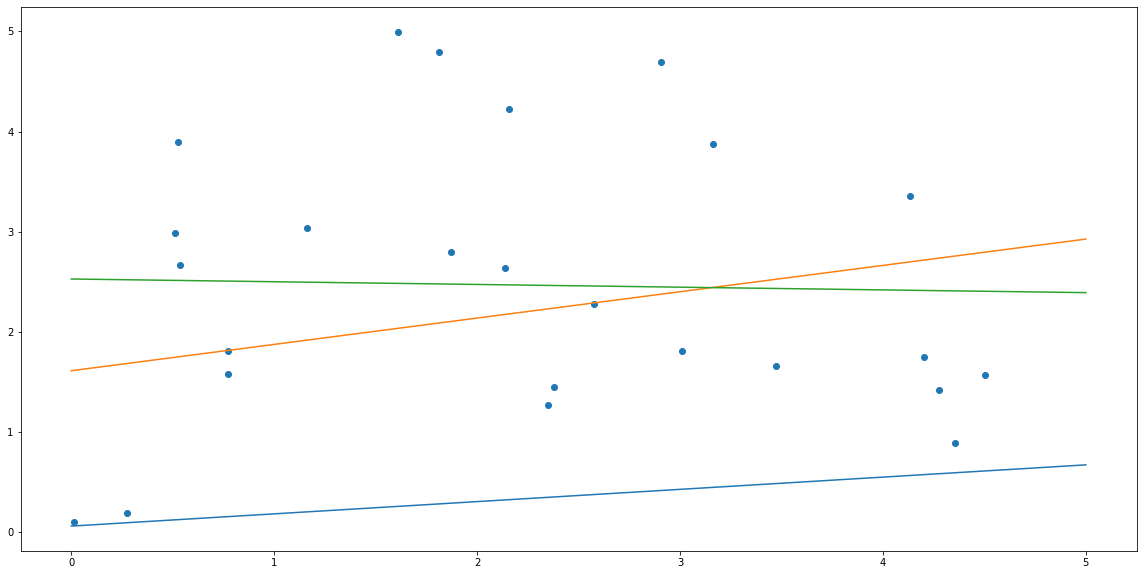

In [23]:
linear = Linear_Regression(0, 5, Mode.RANDOM_POINTS, False, 25)
lin_rate_test_list = np.arange(1e-4, 2e-4, 1e-4)
linear.test_stoch_grad(make_point(0, 0), lin_rate_test_list)
linear.test_minibatch(make_point(0, 0), lin_rate_test_list, max(2, linear.get_points_number() // 5))
linear.test_grad(make_point(0, 0), lin_rate_test_list)
linear.show()

green - GD  
orange - minibatch GD (5 summands)  
blue - SGD


,Linear rate,SGD distance,minibatch distance,GD distance,SGD epochs,minibatch epochs,GD epochs
0,0.00005,179.649783,64.489703,62.664007,327,11176,7712
1,0.00010,176.361606,62.695500,62.664006,251,3448,3856
2,0.00015,95.174628,62.732692,62.664007,9,5906,2570
3,0.00020,95.672750,62.672984,62.664007,43,17924,1927
4,0.00025,176.193751,62.827398,62.664005,5,6122,1542
5,0.00030,128.665945,63.363066,62.664007,1,10591,1284
6,0.00035,83.499882,62.713013,62.664005,186,10925,1101
7,0.00040,91.087175,62.877382,62.664006,3,458,963
8,0.00045,180.313346,62.674707,62.664005,2,3481,856
9,0.00050,97.020593,62.714632,62.664006,29,2929,770


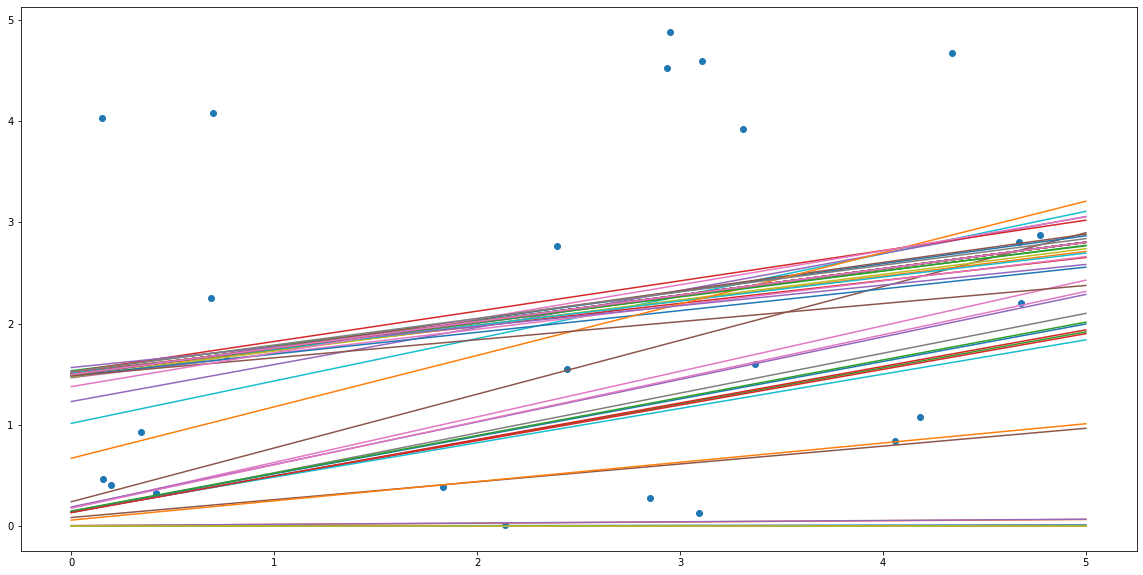

In [24]:
linear = Linear_Regression(0, 5, Mode.RANDOM_POINTS, False, 25)
lin_rate_test_list = np.arange(5e-5, 1e-3, 5e-5)
linear.get_table(make_point(0, 0), lin_rate_test_list, max(2, linear.get_points_number() // 5))

,Linear rate,SGD distance,minibatch distance,GD distance,SGD epochs,minibatch epochs,GD epochs
0,0.00005,1.148874,0.707919,0.000361,4573,3112,5812
1,0.00010,1.093705,0.197290,0.000360,2191,3275,2906
2,0.00015,1.014408,0.350605,0.000360,1533,1346,1937
3,0.00020,1.001333,0.121334,0.000359,1109,873,1453
4,0.00025,1.115532,0.195988,0.000360,907,1368,1162
5,0.00030,1.210254,0.172350,0.000360,740,641,968
6,0.00035,1.202799,0.167926,0.000359,642,624,830
7,0.00040,1.028430,0.417359,0.000359,550,902,726
8,0.00045,1.094445,0.081750,0.000360,500,741,645
9,0.00050,1.090422,0.183229,0.000357,446,841,581


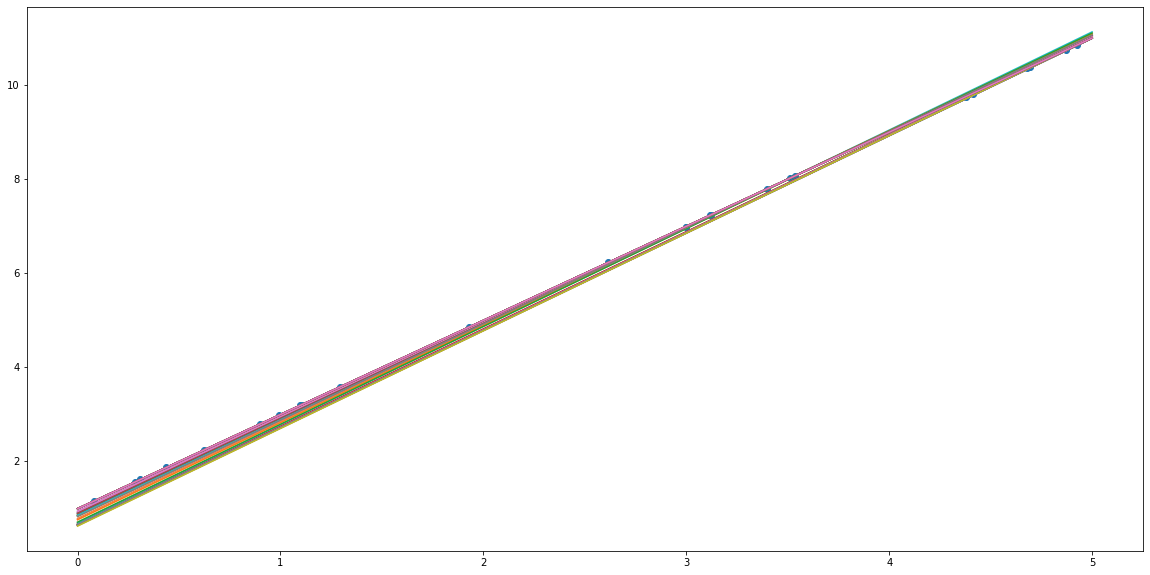

In [25]:
linear = Linear_Regression(0, 5, Mode.POINTS_ON_LINE, False, 25)
lin_rate_test_list = np.arange(5e-5, 1e-3, 5e-5)
linear.get_table(make_point(0, 0), lin_rate_test_list, max(2, linear.get_points_number() // 5))

<h5>Задание 2</h5>

,Linear rate,SGD distance,minibatch distance,GD distance,SGD epochs,minibatch epochs,GD epochs
0,0.00005,124.907001,1.627987,0.000100,41,5072,2806
1,0.00010,122.623487,0.374569,0.000099,77,3109,1402
2,0.00015,122.665437,0.529985,0.000099,31,2368,934
3,0.00020,122.668039,0.137353,0.000099,1,1705,700
4,0.00025,115.892392,0.420859,0.000098,20,1395,560
5,0.00030,122.911740,0.241815,0.000098,83,1081,466
6,0.00035,124.635185,0.076102,0.000099,26,865,399
7,0.00040,116.498136,0.123426,0.000098,50,645,349
8,0.00045,123.223104,0.340125,0.000098,64,505,310
9,0.00050,124.965568,0.197800,0.000096,40,626,279


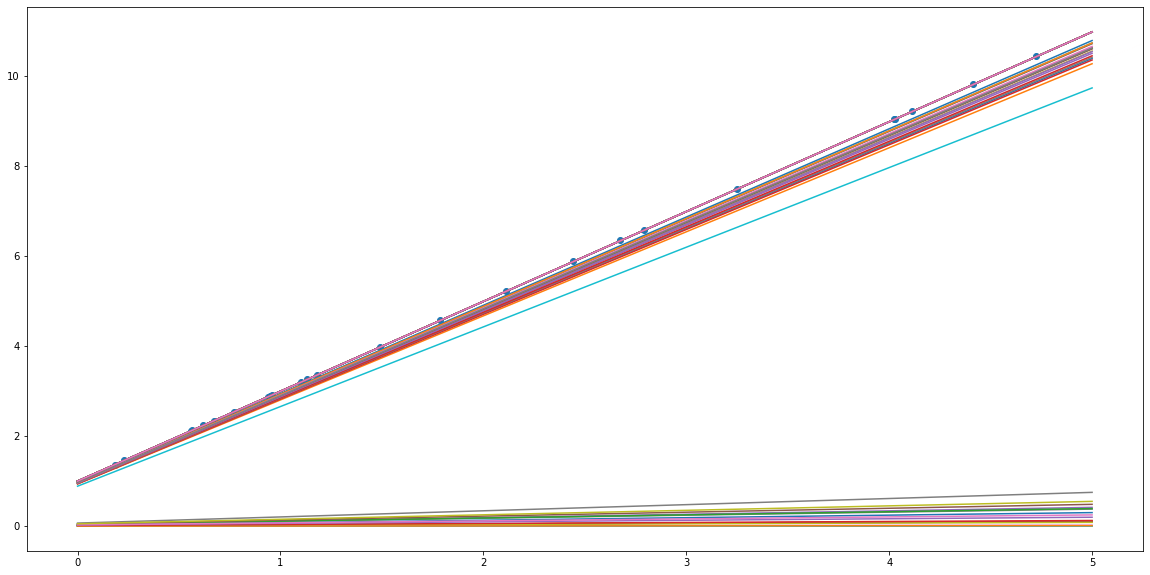

In [26]:
linear = Linear_Regression(0, 5, Mode.POINTS_ON_LINE, True, 25)
lin_rate_test_list = np.arange(5e-5, 1e-3, 5e-5)
linear.get_table(make_point(0, 0), lin_rate_test_list, max(2, linear.get_points_number() // 5))

In [27]:
linear = Linear_Regression(0, 5, Mode.RANDOM_POINTS, True, 25)
lin_rate_test_list = np.arange(5e-5, 1e-3, 5e-5)
linear.get_table(make_point(0, 0), lin_rate_test_list, max(2, linear.get_points_number() // 5))

<h5>Задание 3</h5>


In [ ]:
import time
import enum
from memory_profiler import profile
%load_ext memory_profiler

In [ ]:
stdType = 'float64'

M = 30
spread = 6

beta_1 = 0.9
beta_2 = 0.999

def scalarProd(X, B):
    return np.sum(X * B)

In [ ]:
B_reg = [random.randint(0, spread), random.randint(-spread, spread)]
B_reg = np.array(B_reg, dtype=stdType)

print(B_reg)
XM = []
YM = []
for ind in range(M):
    X = np.array([1, ind])
    rand_delta = random.randint(-spread, spread)
    Y_act = scalarProd(X, B_reg) + 0.5 * rand_delta
    YM.append(Y_act)
    XM.append(np.array(X))
XM = np.array(XM, dtype=stdType)
YM = np.array(YM)

[1. 3.]


In [ ]:
def performSGD(batch, optimType, drawing, lr, eps):
    B_start = np.array([0, 0], dtype=stdType)
    YR = np.array([0] * M, dtype=stdType)
    global calculations
    start = time.time()
    calculations = 0
    B_final, errors, YF, iterations = gradientDescent(batch, XM, YM, YR, B_start, lr, eps, optimType)
    print()
    print(optimType)
    print("numOfBatches:                   ", batch)
    print("calculated coefficients: ", B_final)
    print("number of calculations: ", calculations)
    print("number of gradient iterations:    ", iterations)
    print("time of execution: ", (time.time() - start) * 1000, "ms")
    if drawing:
        draw_graph(XM, YM, YF, batch, optimType)
        draw_errors_graphic(errors, iterations, batch, optimType)

In [ ]:
def calcError(Y_act, Y_reg):
    return np.sum((Y_act - Y_reg)**2) / M

def shouldStop(previous, current, eps):
    return abs(previous - current) < eps

class OptimType(enum.Enum):
    none = 0
    momentum = 1
    Nesterov = 2
    RMSProp = 3
    AdaGrad = 4
    Adam = 5

def gradient(nums, XM, YR, YM):
    global calculations
    grad = []
    for i in range(2):
        xi = 0
        for k in range(len(nums)):
            xi += XM[nums[k]][i] * (YR[nums[k]] - YM[nums[k]])
            calculations = calculations + 1
        xi *= 2
        xi /= M
        grad.append(xi)
    return np.array(grad)

def gradientDescent(batch, XM, YM, YR, BCur, lr, eps, optimType):
    previousError = 0
    grad = np.array([0, 0], dtype=stdType)
    m_adam = np.array([0, 0], dtype=stdType)
    v_adam = np.array([0, 0], dtype=stdType)
    errors = []
    previousGradient = np.array([0, 0], dtype=stdType)
    iterations = 0
    global calculations
    while True:
        nums = np.array(random.sample(list(range(M)), batch))

        calcDelta = 0
        if optimType == OptimType.none:
            grad = gradient(nums, XM, YR, YM)
        elif optimType == OptimType.Nesterov:
            B_prev = BCur - lr * previousGradient
            YR_new = [0] * M
            for i in range(M):
                YR_new[i] = scalarProd(XM[i], B_prev)
            grad = gradient(nums, XM, np.array(YR_new), YM)
            grad += gammaMult * previousGradient
            calcDelta = 2 + M
        elif optimType == OptimType.momentum:
            grad = gradient(nums, XM, YR, YM)
            grad += gammaMult * previousGradient
            calcDelta = 1
        elif optimType == OptimType.AdaGrad:
            grad = gradient(nums, XM, YR, YM)
            new_grad = previousGradient + np.square(grad)
            new_grad = np.divide(grad, np.sqrt(abs(new_grad + eps)))
            grad = new_grad
            calcDelta = 2
        elif optimType == OptimType.Adam:
            grad = gradient(nums, XM, YR, YM)
            m_adam = beta_1 * m_adam + (1 - beta_1) * grad
            v_adam = beta_2 * v_adam + (1 - beta_2) * np.square(grad)
            m = m_adam / (1 - beta_1)
            v = v_adam / (1 - beta_2)
            grad = m / np.sqrt(abs(v + eps))
            calcDelta = 5
        elif optimType == OptimType.RMSProp:
            grad = gradient(nums, XM, YR, YM)
            new_grad = gammaMult * previousGradient + (1 - gammaMult) * np.square(grad)
            new_grad = np.divide(grad, np.sqrt(abs(new_grad + eps)))
            grad = new_grad
            calcDelta = 2
        calculations += calcDelta
        BCur -= lr * grad
        for i in range(M):
            YR[i] = scalarProd(XM[i], BCur)

        if shouldStop(previousError, calcError(YM, YR), eps):
            break
        previousError = calcError(YM, YR)
        previousGradient = grad
        errors.append(previousError)
        iterations += 1
    return BCur, errors, YR, iterations

Графики

In [ ]:
def draw_graph(XM, YM, YF, batch, typeOfOptimisation):
    fig = plt.figure()
    fig.set_size_inches(7, 7)
    X = XM.T[1]
    plt.scatter(X, YM)
    plt.plot(X, YF, color='red')
    title = 'linear regression: batch=' + str(batch) + \
            ', typeOfOptimisation=' + str(typeOfOptimisation)
    plt.title(title)
    plt.show()


def draw_errors_graphic(E, iterations, batch, typeOfOptimisation):
    fig = plt.figure()
    fig.set_size_inches(7, 7)
    i = np.linspace(0, iterations, iterations)
    plt.plot(i, E)
    title = 'error vizualization: batch=' + str(batch) + \
            ', typeOfOptimisation=' + str(typeOfOptimisation)
    plt.title(title)
    plt.show()

Сравнение алгоритмов



OptimType.none
numOfBatches:                    30
calculated coefficients:  [0.15990051 3.00463262]
number of calculations:  600
number of gradient iterations:     9
time of execution:  3.997802734375 ms


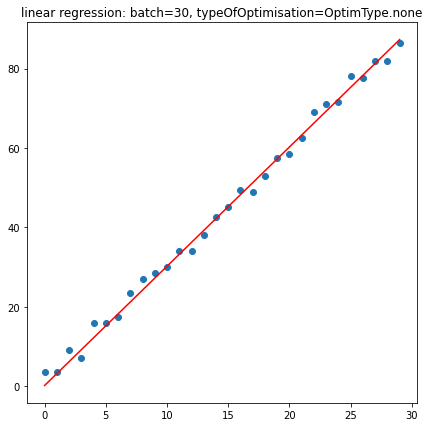

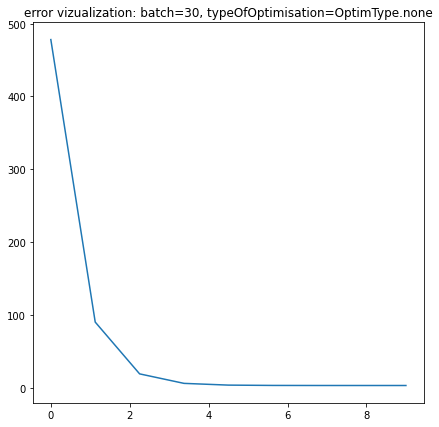

peak memory: 142.04 MiB, increment: 2.18 MiB


NameError: name 'gammaMult' is not defined

In [ ]:
 # none = 0
    # momentum = 1
    # Nesterov = 2
    # RMSProp = 3
    # AdaGrad = 4
    # Adam = 5
    
gamma = 0.9
m_eps = 1e-3
lr = 1e-3
%memit performSGD(M, OptimType.none, True, lr, m_eps)
%memit performSGD(M, OptimType.momentum, True, lr, m_eps)
%memit performSGD(M, OptimType.Nesterov, True, lr, m_eps)
%memit performSGD(M, OptimType.RMSProp, True, lr, m_eps)
%memit performSGD(M, OptimType.AdaGrad, True, lr, m_eps)
%memit performSGD(M, OptimType.Adam, True, lr, m_eps)

In [ ]:
m_eps = 1e-4
lr = 1e-4

%memit performSGD(int(M / 3), OptimType.none, False, lr, m_eps)
%memit performSGD(int(M / 3), OptimType.momentum, False, lr, m_eps)
%memit performSGD(int(M / 3), OptimType.Nesterov, False, lr, m_eps)
%memit performSGD(int(M / 3), OptimType.RMSProp, False, lr, m_eps)
%memit performSGD(int(M / 3), OptimType.AdaGrad, False, lr, m_eps)
%memit performSGD(int(M / 3), OptimType.Adam, False, lr, m_eps)


OptimType.none
numOfBatches:                    10
calculated coefficients:  [-0.01447893 -0.71392197]
number of calculations:  3720
number of gradient iterations:     185
time of execution:  50.43983459472656 ms

OptimType.none
numOfBatches:                    10
calculated coefficients:  [-0.00423599 -0.72921409]
number of calculations:  5560
number of gradient iterations:     277
time of execution:  66.06698036193848 ms
peak memory: 138.24 MiB, increment: -0.09 MiB

OptimType.momentum
numOfBatches:                    10
calculated coefficients:  [ 0.09826839 -0.74337614]
number of calculations:  2478
number of gradient iterations:     117
time of execution:  33.854007720947266 ms

OptimType.momentum
numOfBatches:                    10
calculated coefficients:  [ 0.40229113 -0.76176264]
number of calculations:  8421
number of gradient iterations:     400
time of execution:  93.13201904296875 ms
peak memory: 138.11 MiB, increment: -0.06 MiB

OptimType.Nesterov
numOfBatches:          

In [ ]:
# m_eps = 1e-2
# lr = 1e-5

%memit performSGD(int(M / 2), OptimType.none, False, lr, m_eps)
%memit performSGD(int(M / 2), OptimType.momentum, False, lr, m_eps)
%memit performSGD(int(M / 2), OptimType.Nesterov, False, lr, m_eps)
%memit performSGD(int(M / 2), OptimType.RMSProp, False, lr, m_eps)
%memit performSGD(int(M / 2), OptimType.AdaGrad, False, lr, m_eps)
%memit performSGD(int(M / 2), OptimType.Adam, False, lr, m_eps)


OptimType.none
numOfBatches:                    15
calculated coefficients:  [-0.01002919 -0.72396305]
number of calculations:  4680
number of gradient iterations:     155
time of execution:  40.89713096618652 ms

OptimType.none
numOfBatches:                    15
calculated coefficients:  [-0.0061779  -0.73192853]
number of calculations:  5460
number of gradient iterations:     181
time of execution:  47.53613471984863 ms
peak memory: 138.45 MiB, increment: 0.00 MiB

OptimType.momentum
numOfBatches:                    15
calculated coefficients:  [ 0.24338474 -0.73767488]
number of calculations:  5425
number of gradient iterations:     174
time of execution:  50.975799560546875 ms

OptimType.momentum
numOfBatches:                    15
calculated coefficients:  [ 0.31989574 -0.74433955]
number of calculations:  6758
number of gradient iterations:     217
time of execution:  61.26999855041504 ms
peak memory: 138.45 MiB, increment: 0.00 MiB

OptimType.Nesterov
numOfBatches:            